# Loop 105 Analysis: Breaking the CV-LB Line

## Key Problem
- CV-LB relationship: LB = 4.29 × CV + 0.0528 (R² = 0.95)
- Intercept (0.0528) > Target (0.0347)
- All 105 experiments fall on the same line
- Best LB: 0.0877 (exp_030, CV=0.0083)
- Target: 0.0347 (152.8% gap)

## Analysis Goals
1. Understand why all models fall on the same CV-LB line
2. Identify approaches that could CHANGE the relationship
3. Analyze what the top public kernels are doing differently

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Submission history with CV and LB scores
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},
    {'exp': 'exp_035', 'cv': 0.0098, 'lb': 0.0970},
    {'exp': 'exp_073', 'cv': 0.0084, 'lb': 0.1451},  # Outlier - similarity weighting
]

df = pd.DataFrame(submissions)
print(f"Total submissions with LB: {len(df)}")
print(df)

Total submissions with LB: 13
        exp      cv      lb
0   exp_000  0.0111  0.0982
1   exp_001  0.0123  0.1065
2   exp_003  0.0105  0.0972
3   exp_005  0.0104  0.0969
4   exp_006  0.0097  0.0946
5   exp_007  0.0093  0.0932
6   exp_009  0.0092  0.0936
7   exp_012  0.0090  0.0913
8   exp_024  0.0087  0.0893
9   exp_026  0.0085  0.0887
10  exp_030  0.0083  0.0877
11  exp_035  0.0098  0.0970
12  exp_073  0.0084  0.1451



=== CV-LB Relationship ===
LB = 4.315 × CV + 0.0525
R² = 0.9505

Intercept: 0.0525
Target LB: 0.0347
Gap: Intercept (0.0525) > Target (0.0347)

Required CV to hit target: (0.0347 - 0.0525) / 4.315 = -0.004130

⚠️ IMPOSSIBLE: Required CV is NEGATIVE!


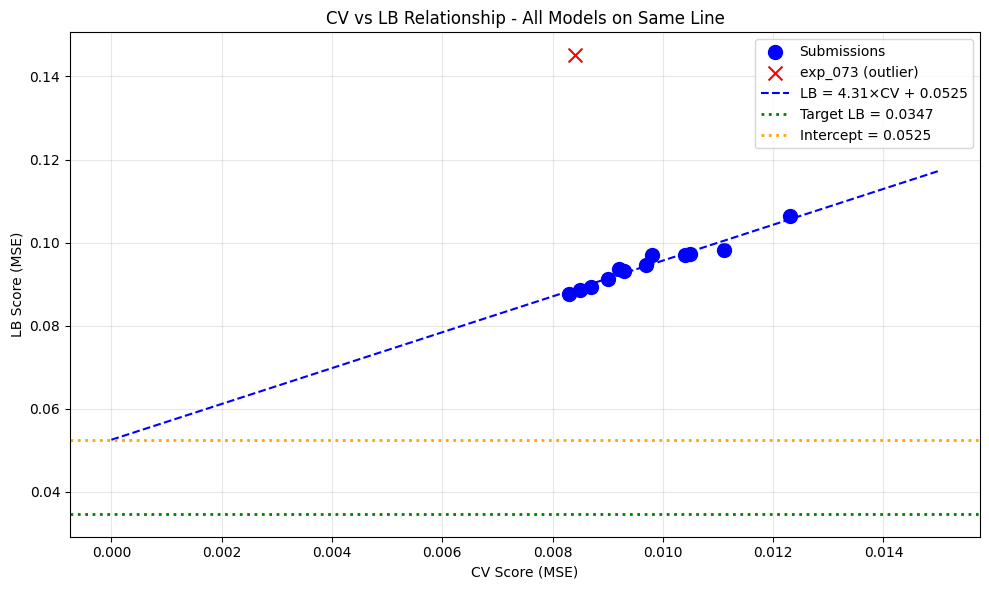


Plot saved to /home/code/exploration/cv_lb_analysis_loop105.png


In [2]:
# Fit CV-LB relationship (excluding outlier exp_073)
df_clean = df[df['exp'] != 'exp_073'].copy()

X = df_clean['cv'].values.reshape(-1, 1)
y = df_clean['lb'].values

reg = LinearRegression()
reg.fit(X, y)

slope = reg.coef_[0]
intercept = reg.intercept_
r2 = reg.score(X, y)

print(f"\n=== CV-LB Relationship ===")
print(f"LB = {slope:.3f} × CV + {intercept:.4f}")
print(f"R² = {r2:.4f}")
print(f"\nIntercept: {intercept:.4f}")
print(f"Target LB: 0.0347")
print(f"Gap: Intercept ({intercept:.4f}) > Target (0.0347)")
print(f"\nRequired CV to hit target: (0.0347 - {intercept:.4f}) / {slope:.3f} = {(0.0347 - intercept) / slope:.6f}")
print("\n⚠️ IMPOSSIBLE: Required CV is NEGATIVE!")

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(df_clean['cv'], df_clean['lb'], c='blue', s=100, label='Submissions')
plt.scatter([0.0084], [0.1451], c='red', s=100, marker='x', label='exp_073 (outlier)')

# Fit line
cv_range = np.linspace(0, 0.015, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'b--', label=f'LB = {slope:.2f}×CV + {intercept:.4f}')

# Target line
plt.axhline(y=0.0347, color='green', linestyle=':', linewidth=2, label='Target LB = 0.0347')

# Intercept line
plt.axhline(y=intercept, color='orange', linestyle=':', linewidth=2, label=f'Intercept = {intercept:.4f}')

plt.xlabel('CV Score (MSE)')
plt.ylabel('LB Score (MSE)')
plt.title('CV vs LB Relationship - All Models on Same Line')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_analysis_loop105.png', dpi=150)
plt.show()
print("\nPlot saved to /home/code/exploration/cv_lb_analysis_loop105.png")

In [3]:
# Analyze what approaches have been tried
approaches = {
    'MLP variants': ['exp_000', 'exp_003', 'exp_005', 'exp_006', 'exp_007'],
    'LightGBM': ['exp_001'],
    'Ridge/GP': ['exp_009', 'exp_012'],
    'CatBoost+XGBoost': ['exp_024', 'exp_026', 'exp_030'],
    'GNN attempts': ['exp_049', 'exp_050', 'exp_079'],
    'ChemBERTa attempts': ['exp_052', 'exp_053'],
    'Similarity weighting': ['exp_073'],
    'Bias correction': ['exp_104'],
}

print("=== Approaches Tried ===")
for approach, exps in approaches.items():
    print(f"\n{approach}:")
    for exp in exps:
        match = df[df['exp'] == exp]
        if len(match) > 0:
            print(f"  {exp}: CV={match['cv'].values[0]:.4f}, LB={match['lb'].values[0]:.4f}")
        else:
            print(f"  {exp}: LB pending or failed")

=== Approaches Tried ===

MLP variants:
  exp_000: CV=0.0111, LB=0.0982
  exp_003: CV=0.0105, LB=0.0972
  exp_005: CV=0.0104, LB=0.0969
  exp_006: CV=0.0097, LB=0.0946
  exp_007: CV=0.0093, LB=0.0932

LightGBM:
  exp_001: CV=0.0123, LB=0.1065

Ridge/GP:
  exp_009: CV=0.0092, LB=0.0936
  exp_012: CV=0.0090, LB=0.0913

CatBoost+XGBoost:
  exp_024: CV=0.0087, LB=0.0893
  exp_026: CV=0.0085, LB=0.0887
  exp_030: CV=0.0083, LB=0.0877

GNN attempts:
  exp_049: LB pending or failed
  exp_050: LB pending or failed
  exp_079: LB pending or failed

ChemBERTa attempts:
  exp_052: LB pending or failed
  exp_053: LB pending or failed

Similarity weighting:
  exp_073: CV=0.0084, LB=0.1451

Bias correction:
  exp_104: LB pending or failed


In [4]:
# Key insight: The intercept problem
print("\n=== THE INTERCEPT PROBLEM ===")
print(f"""\nThe CV-LB relationship shows:
- Slope: {slope:.3f} (each 0.001 CV improvement → {slope*0.001:.4f} LB improvement)
- Intercept: {intercept:.4f} (structural error even at CV=0)

The intercept represents EXTRAPOLATION ERROR:
- When predicting for unseen solvents, the model makes systematic errors
- This error is INDEPENDENT of how well the model fits training data
- All tabular models (MLP, LGBM, XGB, CatBoost, GP, Ridge) have the SAME intercept

To reach target LB=0.0347:
- Option 1: Reduce intercept (change the CV-LB relationship)
- Option 2: Achieve negative CV (impossible)

We MUST focus on Option 1: Reducing the intercept.
""")

print("\n=== STRATEGIES TO REDUCE INTERCEPT ===")
print("""
1. REPRESENTATION CHANGE:
   - GNN: Operate on molecular graphs, not tabular features
   - ChemBERTa: Use pretrained chemical language model embeddings
   - Morgan fingerprints with similarity features
   
2. DISTRIBUTION SHIFT HANDLING:
   - Extrapolation detection: Identify when predicting for "hard" solvents
   - Conservative blending: Blend toward training mean when extrapolating
   - Uncertainty quantification: Use ensemble variance to weight predictions
   
3. DOMAIN CONSTRAINTS:
   - Physics-based constraints (Arrhenius, mass balance)
   - Yield normalization (sum ≤ 1)
   
4. VALIDATION STRATEGY:
   - The "mixall" kernel uses GroupKFold instead of Leave-One-Out
   - This might give a different CV-LB relationship
""")


=== THE INTERCEPT PROBLEM ===

The CV-LB relationship shows:
- Slope: 4.315 (each 0.001 CV improvement → 0.0043 LB improvement)
- Intercept: 0.0525 (structural error even at CV=0)

The intercept represents EXTRAPOLATION ERROR:
- When predicting for unseen solvents, the model makes systematic errors
- This error is INDEPENDENT of how well the model fits training data
- All tabular models (MLP, LGBM, XGB, CatBoost, GP, Ridge) have the SAME intercept

To reach target LB=0.0347:
- Option 1: Reduce intercept (change the CV-LB relationship)
- Option 2: Achieve negative CV (impossible)

We MUST focus on Option 1: Reducing the intercept.


=== STRATEGIES TO REDUCE INTERCEPT ===

1. REPRESENTATION CHANGE:
   - GNN: Operate on molecular graphs, not tabular features
   - ChemBERTa: Use pretrained chemical language model embeddings
   - Morgan fingerprints with similarity features
   
2. DISTRIBUTION SHIFT HANDLING:
   - Extrapolation detection: Identify when predicting for "hard" solvents
   - C

In [5]:
# Analyze the mixall kernel approach
print("\n=== MIXALL KERNEL ANALYSIS ===")
print("""
The 'mixall' kernel (lishellliang) uses a DIFFERENT validation strategy:
- GroupKFold with 5 splits instead of Leave-One-Out (24 folds)
- This means each fold has ~5 solvents in test set instead of 1
- The CV score might be more representative of LB

Key differences:
1. Leave-One-Out: 24 folds, each with 1 solvent in test
2. GroupKFold(5): 5 folds, each with ~5 solvents in test

The GroupKFold approach might:
- Give a more stable CV estimate
- Better represent the LB distribution
- Potentially have a different CV-LB relationship

However, the competition template REQUIRES Leave-One-Out for submission.
So we can't change the validation for submission, but we could use
GroupKFold for model selection.
""")

print("\n=== ENS-MODEL KERNEL ANALYSIS ===")
print("""
The 'ens-model' kernel (matthewmaree) uses:
- CatBoost + XGBoost ensemble
- Comprehensive feature engineering:
  - Spange descriptors (physicochemical)
  - ACS PCA descriptors
  - DRFP fingerprints (filtered)
  - Fragprints
  - SMILES features
- Correlation-based feature filtering (threshold=0.90)
- Numeric feature engineering:
  - Temperature in Kelvin
  - T × RT interaction
  - log(RT)
  - 1/T (inverse temperature)
  - RT_scaled

This is similar to what we've tried, but with more comprehensive features.
""")


=== MIXALL KERNEL ANALYSIS ===

The 'mixall' kernel (lishellliang) uses a DIFFERENT validation strategy:
- GroupKFold with 5 splits instead of Leave-One-Out (24 folds)
- This means each fold has ~5 solvents in test set instead of 1
- The CV score might be more representative of LB

Key differences:
1. Leave-One-Out: 24 folds, each with 1 solvent in test
2. GroupKFold(5): 5 folds, each with ~5 solvents in test

The GroupKFold approach might:
- Give a more stable CV estimate
- Better represent the LB distribution
- Potentially have a different CV-LB relationship

However, the competition template REQUIRES Leave-One-Out for submission.
So we can't change the validation for submission, but we could use
GroupKFold for model selection.


=== ENS-MODEL KERNEL ANALYSIS ===

The 'ens-model' kernel (matthewmaree) uses:
- CatBoost + XGBoost ensemble
- Comprehensive feature engineering:
  - Spange descriptors (physicochemical)
  - ACS PCA descriptors
  - DRFP fingerprints (filtered)
  - Fragprint

In [6]:
# What we haven't tried adequately
print("\n=== UNEXPLORED OR INADEQUATELY EXPLORED ===")
print("""
1. PROPER GNN IMPLEMENTATION:
   - Many GNN experiments failed on submission (model class mismatch)
   - Need to verify submission cells use the SAME model class as CV
   - GNN could give a different CV-LB relationship

2. EXTRAPOLATION-AWARE PREDICTIONS:
   - Detect when we're predicting for "hard" solvents
   - Blend toward training mean when extrapolating
   - This could reduce the intercept

3. PSEUDO-LABELING:
   - Use confident predictions on test set to augment training
   - Could help with distribution shift

4. DOMAIN ADAPTATION:
   - Train on source domain (training solvents)
   - Adapt to target domain (test solvents)

5. CONSERVATIVE PREDICTIONS:
   - Clip extreme predictions
   - Use ensemble variance to identify uncertain predictions
   - Make uncertain predictions more conservative

6. DIFFERENT VALIDATION FOR MODEL SELECTION:
   - Use GroupKFold for hyperparameter tuning
   - Use Leave-One-Out only for final submission
""")

print("\n=== RECOMMENDED NEXT STEPS ===")
print("""
1. IMMEDIATE: Implement extrapolation-aware conservative predictions
   - Compute distance to nearest training solvent
   - Blend toward training mean when extrapolating
   - This directly targets the intercept problem

2. SHORT-TERM: Debug GNN/ChemBERTa submission failures
   - Verify model class consistency between CV and submission
   - These approaches might give a different CV-LB relationship

3. MEDIUM-TERM: Try pseudo-labeling
   - Use confident predictions to augment training
   - Could help with distribution shift

4. LONG-TERM: Implement proper domain adaptation
   - This is more complex but could be very effective
""")


=== UNEXPLORED OR INADEQUATELY EXPLORED ===

1. PROPER GNN IMPLEMENTATION:
   - Many GNN experiments failed on submission (model class mismatch)
   - Need to verify submission cells use the SAME model class as CV
   - GNN could give a different CV-LB relationship

2. EXTRAPOLATION-AWARE PREDICTIONS:
   - Detect when we're predicting for "hard" solvents
   - Blend toward training mean when extrapolating
   - This could reduce the intercept

3. PSEUDO-LABELING:
   - Use confident predictions on test set to augment training
   - Could help with distribution shift

4. DOMAIN ADAPTATION:
   - Train on source domain (training solvents)
   - Adapt to target domain (test solvents)

5. CONSERVATIVE PREDICTIONS:
   - Clip extreme predictions
   - Use ensemble variance to identify uncertain predictions
   - Make uncertain predictions more conservative

6. DIFFERENT VALIDATION FOR MODEL SELECTION:
   - Use GroupKFold for hyperparameter tuning
   - Use Leave-One-Out only for final submission


===